## Create Helper Functions

In [2]:
import sqlite3
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def run_query(q):
    # Take an SQL query and return a pandas dataframe of the query
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
    
def run_command(c):
    # Take an SQL command and execute it
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
    
def show_tables():
    # Return a list of all tables and views in the database
    q = '''SELECT
                name,
                type
            FROM sqlite_master
            WHERE type IN ("table","view");'''
    return run_query(q)
    
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Selecting Albums to Purchase

In [3]:
genre_query = '''
    WITH usa_invoice_line AS
        (
        SELECT il.*
        FROM invoice_line il
        INNER JOIN invoice i ON i.invoice_id = il.invoice_id
        INNER JOIN customer c on c.customer_id = i.customer_id
        WHERE c.country = "USA"
        )
        
    SELECT
        g.name genre,
        COUNT(uil.invoice_line_id) tracks_sold,
        CAST(COUNT(uil.invoice_line_id) AS FLOAT) / 
            (SELECT COUNT(*) from usa_invoice_line) percentage_sold
    FROM genre g
    INNER JOIN track t ON t.genre_id = g.genre_id
    INNER JOIN usa_invoice_line uil ON uil.track_id = t.track_id
    GROUP BY g.genre_id
    ORDER BY tracks_sold DESC
    LIMIT 10;'''

run_query(genre_query)

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


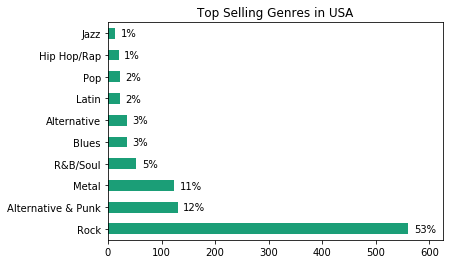

In [4]:
genre_sales = run_query(genre_query)
genre_sales.set_index('genre',drop=True,inplace=True)

genre_sales.tracks_sold.plot.barh(
    title = 'Top Selling Genres in USA',
    colormap=plt.cm.Dark2,
    xlim=(0,625))

plt.ylabel('')

for i, label in enumerate(list(genre_sales.index)):
    score = genre_sales.loc[label, "tracks_sold"]
    label = (genre_sales.loc[label, "percentage_sold"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show()

Considering the following four albums and their genres.

| Artist Name | Genre |
| --- | --- |
|Regal|Hip-Hop|
|Red Tone|Punk|
|Meteor and the Girls|Pop|
|Slim Jim Bites|Blues|

If we need to select three of the four albums to add to the store, we would leave out the Regal album because Hip-Hop is our customers least purchased genre of the four.

## Analyzing Employee Sales Performance

We look at the total sales attributed to each Sales Support Agent at the store. We will take a look at several other attributes of these employees to see if anything else can explain sales variance or if it is indicative of performance.

Other attributes:
- age
- length of employment
- location
- supervisor

In [5]:
run_query("select * from employee;")

employee_sales_query = '''
    SELECT 
        e.first_name || " " || e.last_name employee_name,
        SUM(i.total) total_sales,
        s.first_name || " " || s.last_name supervisor_name,
        cast(strftime("%Y",date()) - strftime("%Y",date(e.birthdate)) as int) age,
        cast(julianday() - julianday(e.hire_date) as int)  days_employed,
        e.city city
    FROM employee e
    INNER JOIN employee s ON s.employee_id = e.reports_to
    INNER JOIN customer c ON c.support_rep_id = e.employee_id
    INNER JOIN invoice i ON i.customer_id = c.customer_id
    GROUP BY e.employee_id
    HAVING e.title = "Sales Support Agent";'''

run_query(employee_sales_query)

,employee_name,total_sales,supervisor_name,age,days_employed,city
0,Jane Peacock,1731.51,Nancy Edwards,45,445,Calgary
1,Margaret Park,1584.00,Nancy Edwards,71,413,Calgary
2,Steve Johnson,1393.92,Nancy Edwards,53,246,Calgary


We can see that each of the three Sales Support Agents has the same supervisor and location so we will take a look at total sales against employee age and length of employment.

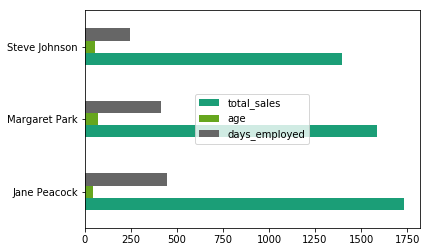

In [6]:
employee_sales = run_query(employee_sales_query)
employee_sales = employee_sales.set_index('employee_name')
axes = employee_sales.plot.barh(
    colormap = plt.cm.Dark2)
axes.legend(loc = 10)
plt.ylabel("")
plt.show()

Looking at our three Sales Support Agents, we can see that age doesn't seem to have a bearing on total sales amounts. However, employees that have been employed longer have higher total sales indicating that the total sales number may not be indicative of performance, but rather amount of time making sales.

A better indicator of performance might be total_sales over time employed or looking at how employee sales change over time.

In [7]:
employee_sales['total_sales'] / employee_sales['days_employed']

employee_name
Jane Peacock     3.891034
Margaret Park    3.835351
Steve Johnson    5.666341
dtype: float64

Here we see that Jane and Margaret have similar sales figures over time, but that Steve's figure is higher indicating he has sold a good amount for his relatively short time at the store.

In [8]:
sales_over_time_query = '''
        SELECT
            e.first_name || " " || e.last_name employee,
            julianday(i.invoice_date) - julianday(e.hire_date) employment_age,
            i.total amount
        FROM invoice i 
        INNER JOIN customer c on c.customer_id = i.customer_id
        INNER JOIN employee e on e.employee_id = c.support_rep_id
        WHERE e.title = "Sales Support Agent";'''
run_query(sales_over_time_query).head()

,employee,employment_age,amount
0,Jane Peacock,-88.0,15.84
1,Jane Peacock,-88.0,9.90
2,Margaret Park,-118.0,1.98
3,Jane Peacock,-85.0,7.92
4,Margaret Park,-116.0,16.83


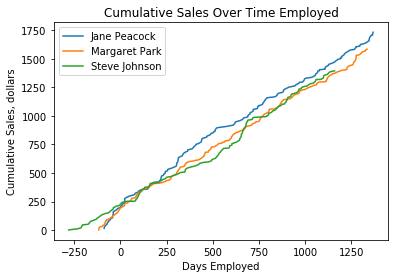

In [9]:
sot = run_query(sales_over_time_query)

#Create employee sales over time series and plot
fig = plt.figure()
ax1 = plt.subplot(111)
for employee in sot['employee'].unique():
    target_sot = sot[sot['employee'] == employee].copy()
    target_sot["cumulative_amt"] = target_sot['amount'].cumsum()
    target_sot.plot(x='employment_age',y='cumulative_amt',
                    ax = ax1)
plt.legend(sot['employee'].unique(),loc='best')
plt.title("Cumulative Sales Over Time Employed")
plt.xlabel("Days Employed")
plt.ylabel("Cumulative Sales, dollars")
plt.show()

When looking at cumulative sales over time employed we see that we have a problem with our data model in that we link an invoice to a Sales Support Agent through the customer -  who can only have on Sales Support Agent assigned to them. So a customer's previous sales with another Sales Support Agent get assigned to their current sales support agent in our metrics above. This is evidenced by the fact that each current Sales Support Agent has invoices associated with them from before they were employed at the store.

If we ignore this we see that cumulative sales over time is fairly similar for our three Sales Support Agents meaning they have been performing similar to one another.

## Analyzing Sales by Country


In [10]:
country_sales_query = '''
    WITH country_sales AS
        (
            SELECT
                c.country country,
                COUNT(DISTINCT c.customer_id) customers,
                SUM(i.total) sales_value,
                COUNT(i.invoice_id) num_sales
            FROM customer c
            INNER JOIN invoice i ON i.customer_id = c.customer_id
            GROUP BY c.country
        ),
        
        country_sales_w_other AS
        (
            SELECT
                CASE
                    WHEN cs.customers = 1 THEN "Other"
                    ELSE cs.country
                END AS country,
                cs.customers,
                cs.sales_value,
                cs.num_sales
            FROM country_sales cs                
        ),
        
        country_sales_other_collate AS
        (
            SELECT 
                country,
                SUM(customers) customers,
                SUM(sales_value) sales_value,
                SUM(num_sales) num_sales
            FROM country_sales_w_other
            GROUP BY country
            ORDER BY sales_value DESC
        )
        
        SELECT
            country,
            customers,
            sales_value total_value,
            CAST(sales_value AS FLOAT) / customers customer_value,
            CAST(sales_value AS FLOAT) / num_sales order_value
        FROM
            (
            SELECT 
                cs.*,
                CASE
                    WHEN cs.country = "Other" THEN 1
                    ELSE 0
                END AS sort
                FROM country_sales_other_collate cs
            )
        ORDER BY sort ASC;
        '''
            
run_query(country_sales_query)

,country,customers,total_value,customer_value,order_value
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Other,15,1094.94,72.996000,7.448571


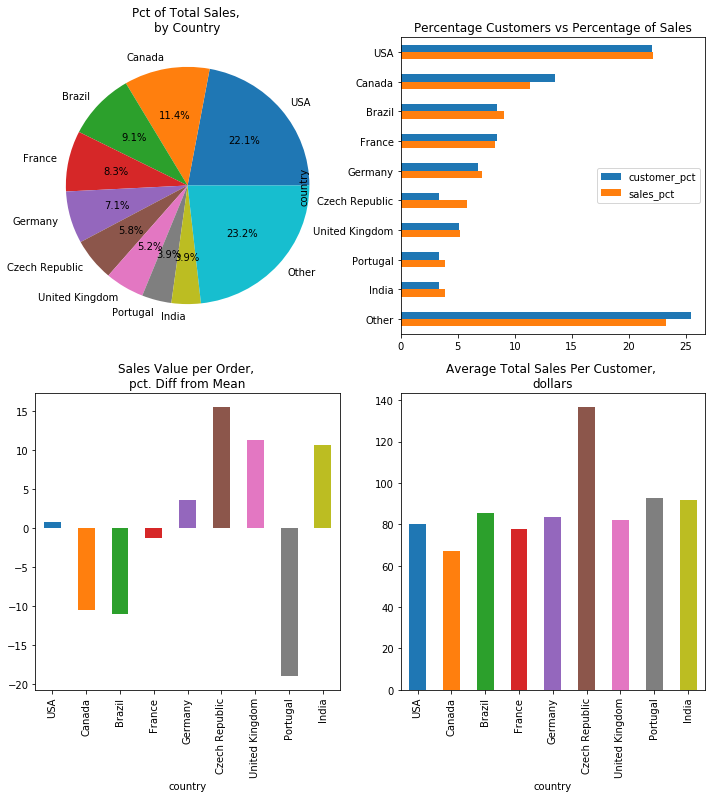

In [11]:
#plt.style.use('default')
fig,axes = plt.subplots(2,2,figsize=(12,12))


country_sales = run_query(country_sales_query).set_index('country',drop=True)


country_sales.total_value.plot.pie(ax=axes[0,0],autopct='%1.1f%%')
axes[0][0].set_title("Pct of Total Sales, \nby Country")
axes[0][0].set_ylabel("")


country_sales["customer_pct"] = 100 * (country_sales.customers / country_sales.customers.sum())
country_sales["sales_pct"] = 100 * (country_sales.total_value / country_sales.total_value.sum())

country_sales[["customer_pct","sales_pct"]].plot.barh(ax=axes[0,1])
axes[0,1].invert_yaxis()
axes[0,1].set_title("Percentage Customers vs Percentage of Sales")


cv = country_sales.order_value.drop("Other")
md = 100*((cv - cv.mean())/cv.mean())
md.plot.bar(ax=axes[1,0])
axes[1,0].set_title("Sales Value per Order, \npct. Diff from Mean")


country_sales.drop("Other").customer_value.plot.bar(ax=axes[1,1])
axes[1,1].set_title("Average Total Sales Per Customer, \ndollars")

plt.show()

The Czech Republic, United Kingdom and India all have average order value over 10% difference from the mean order value. We may want to target these countries for growth. However, each of these countries has a relatively small sample size, so we should not commit too many resources to this task.

## Albums vs Individual Tracks

In [12]:
album_query = '''
    SELECT i.*,
    CASE
        WHEN
            (
                
                SELECT track_id
                FROM track
                WHERE album_id = ilt.album_id
                               
                EXCEPT                
                
                SELECT track_id 
                FROM invoice_line
                WHERE invoice_line.invoice_id = i.invoice_id
                
            ) IS NULL
            
            AND 
            
            (
                
                SELECT track_id 
                FROM invoice_line
                WHERE invoice_line.invoice_id = i.invoice_id
                               
                EXCEPT                
                
                SELECT track_id
                FROM track
                WHERE album_id = ilt.album_id
                                
            )    IS NULL THEN 1
        ELSE 0
    END AS full_album
    FROM invoice i
    INNER JOIN invoice_line il ON il.invoice_id = i.invoice_id
    INNER JOIN track ilt ON ilt.track_id = il.track_id
    GROUP BY i.invoice_id;'''

invoice_w_album = run_query(album_query)
print("Invoices for Full Albums Summary Stats \n------------")
print("Number of invoices: ", invoice_w_album.full_album.sum())
print("Percentage of invoices: ", 100*invoice_w_album.full_album.sum()/invoice_w_album.shape[0], " %")

album_revenue = invoice_w_album[invoice_w_album['full_album'] == 1].total.sum()
total_revenue = invoice_w_album.total.sum()
print("\nRevenue from Full Albums: ",album_revenue)
print("Percentage of Total Revenue: ",100*album_revenue/total_revenue, "%")

Invoices for Full Albums Summary Stats 
------------
Number of invoices:  114
Percentage of invoices:  18.566775244299674  %

Revenue from Full Albums:  1461.24
Percentage of Total Revenue:  31.027958797561485 %


About 19% of orders are for full albums and these orders account for 31% of the store's revenue. If the store adopted the "popular tracks" purchasing strategy it could stand to lose a significant portion (up to 31%) of it's revenue as customers who would prefer to purchase a full album would have to go elsewhere.

## Extra Practice: More Business Questions

- Which artist is used in the most playlists?
- How many tracks have been purchased vs not purchased?
- Is the range of tracks in the store reflective of their sales popularity?
- Do protected vs non-protected media types have an effect on popularity?

### Which artist is used in the most playlists?

In [13]:
playlist_artist_query = '''
    SELECT
        ar.name artist,
        COUNT(DISTINCT(plt.playlist_id)) num_playlists,
        COUNT(DISTINCT(t.track_id)) tracks_on_playlists
    FROM artist ar
    INNER JOIN album al on al.artist_id = ar.artist_id
    INNER JOIN track t on t.album_id = al.album_id
    INNER JOIN playlist_track plt on plt.track_id = t.track_id
    GROUP BY ar.artist_id
    ORDER BY num_playlists DESC
    LIMIT 20;'''

run_query(playlist_artist_query)

,artist,num_playlists,tracks_on_playlists
0,Eugene Ormandy,7,3
1,English Concert & Trevor Pinnock,6,2
2,Academy of St. Martin in the Fields & Sir Nevi...,6,2
3,The King's Singers,6,2
4,Berliner Philharmoniker & Herbert Von Karajan,6,3
5,Alberto Turco & Nova Schola Gregoriana,5,1
6,"Richard Marlow & The Choir of Trinity College,...",5,1
7,Wilhelm Kempff,5,1
8,Yo-Yo Ma,5,1
9,Scholars Baroque Ensemble,5,1


### How many tracks have been purchased vs not purchased?

In [49]:
purchased_query = """
    WITH track_sales as 
        (SELECT 
            t.*,
            COUNT(invoice_line_id) num_sold
        FROM track t
        LEFT JOIN invoice_line il on il.track_id = t.track_id
        GROUP BY t.track_id
        )
        
    SELECT COUNT(*) purchased_tracks
    FROM track_sales
    WHERE num_sold = 0
    
    UNION
    
    SELECT COUNT(*) 
    FROM track_sales
    WHERE num_sold > 0;"""

run_query(purchased_query)


,purchased_tracks
0,1697
1,1806


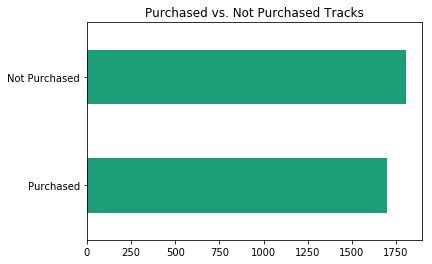

In [50]:
track_sales = run_query(track_sales_query)
ax =track_sales.plot.barh(title="Purchased vs. Not Purchased Tracks",
                      colormap=plt.cm.Dark2,
                      legend="")
ax.set_yticklabels(['Purchased','Not Purchased'])

plt.show()

The store has more has more tracks in stock that have never been purchased than tracks than have been purchased. It may be wise to look at the list of unpurchased tracks and review whether or not they should continue to be offered on the store.

### Is the range of tracks in the store reflective of their sales popularity?

To determine if the range of tracks offered is reflective of sales popularity we can look at the distribution of the number of sales of each track.

In [52]:
track_sales_query = """
    SELECT 
        t.*,
        COUNT(invoice_line_id) num_sold
    FROM track t
    LEFT JOIN invoice_line il on il.track_id = t.track_id
    GROUP BY t.track_id;"""
run_query(track_sales_query).head()

,track_id,name,album_id,media_type_id,genre_id,composer,milliseconds,bytes,unit_price,num_sold
0,1,For Those About To Rock (We Salute You),1,1,1,"Angus Young, Malcolm Young, Brian Johnson",343719,11170334,0.99,8
1,2,Balls to the Wall,2,2,1,None,342562,5510424,0.99,3
2,3,Fast As a Shark,3,2,1,"F. Baltes, S. Kaufman, U. Dirkscneider & W. Ho...",230619,3990994,0.99,1
3,4,Restless and Wild,3,2,1,"F. Baltes, R.A. Smith-Diesel, S. Kaufman, U. D...",252051,4331779,0.99,4
4,5,Princess of the Dawn,3,2,1,Deaffy & R.A. Smith-Diesel,375418,6290521,0.99,1


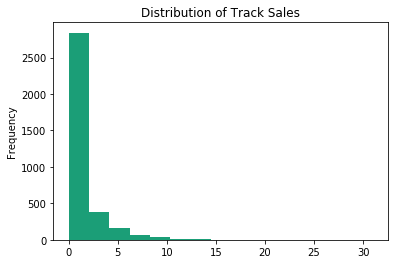

In [59]:
track_sales = run_query(track_sales_query)
track_sales.num_sold.plot.hist(title = "Distribution of Track Sales",
                          bins=15,
                          colormap=plt.cm.Dark2)
plt.show()

The distribution shows that htere are very few tracks with high sales numbers and the vast majority of tracks have been purchased less than three times. So range of tracks does not seem to reflect sales popularity as adding a wide range of tracks doesn't as much sales as adding particularly popular tracks.

### Do protected vs non-protected media types have an effect on popularity?

In [80]:
protected_query = """
    WITH media_type_p AS
        (
        SELECT
            media_type_id,
            name,
            CASE
                WHEN name LIKE '%Protected%' THEN "Protected"
                ELSE "Not Protected"
                END
                AS protected
        FROM media_type
        ),
        
    track_sales AS
        (
        SELECT 
            t.*,
            COUNT(invoice_line_id) num_sold
        FROM track t
        LEFT JOIN invoice_line il on il.track_id = t.track_id
        GROUP BY t.track_id
        )
        
    SELECT 
        mt.protected,
        SUM(ts.num_sold) total_sales,
        AVG(ts.num_sold) average_sales
    FROM track_sales ts
    INNER JOIN media_type_p mt on mt.media_type_id = ts.media_type_id
    GROUP BY mt.protected;"""
    
run_query(protected_query)

,protected,total_sales,average_sales
0,Not Protected,4315,1.413827
1,Protected,442,0.980044


Unprotected tracks may be more popular with the stores customers as an unprotected track sells 1.41 units on average, whereas a protected track only sells .98 units on average. The store may want to look into getting unprotected versions of the tracks with are protected and prioritizing unprotected tracks in the future.